# Deep learning thực nghiệm 

## Thí nghiệm 5: Theo dõi, kết thúc sớm và sao lưu mô hình theo tiêu chí tùy chọn

**Lê Ngọc Khả Nhi**

Chào các bạn, hôm nay chúng ta lại gặp nhau trong một thí nghiệm khác về Deep learning. Lần này, chúng ta sẽ thử nghiệm một tính năng thú vị, đó là khả năng theo dõi quá trình huấn luyện, cập nhật và sao lưu những phiên bản mô hình mới và chủ động chấm dứt việc huấn luyện khi mô hình đã đạt trạng thái tối ưu, dựa vào một tiêu chí tùy chọn.

Trong bài, Nhi sẽ lần lượt thực hiện 2 thử nghiệm:

A) Một bài toán phân lớp 2 nhãn (nhị phân), sử dụng F1 score làm tiêu chí huấn luyện
B) Một bài toán phân lớp 6 nhãn, sử dụng Cohen's Kappa làm tiêu chí huấn luyện

Trong mỗi bài toán, ta sẽ lần lượt làm 4 bước:

1) Tạo dữ liệu mô phỏng bằng scikitlearn

2) Viết một hàm cho phép tính tiêu chí tùy chọn để đưa vào keras backend (dùng tensorflow contrib)

3) Thiết lập chế độ theo dõi, cập nhật/sao lưu và chấm dứt sớm việc huấn luyện

4) Huấn luyện mô hình rồi vẽ biểu đồ diễn tiến cho tiêu chí đã chọn


In [1]:
# numpy
import numpy as np
from numpy import where

# Đồ họa

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-whitegrid')
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# keras và tensorflow

import tensorflow as tf

from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical
from sklearn.utils import class_weight
from keras.callbacks import Callback
from keras import backend as K

Using TensorFlow backend.


## Chuẩn bị hàm mô phỏng

In [14]:
# Hàm tạo dữ liệu mô phỏng 

from sklearn.datasets.samples_generator import make_blobs

def create_dataset(size = 1000,
                   labels = 4,
                   n_features = 20,
                   noise_std = 20,
                   train_ratio=0.5):
    X, y = make_blobs(n_samples = size, 
                      centers = labels, 
                      n_features = n_features, 
                      cluster_std = noise_std)
    
    plt.figure(figsize=(10,10))
    for class_value in range(5):
        row_id = where(y == class_value)
        plt.scatter(X[row_id, 0], 
                X[row_id, 1],
                alpha=0.5)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()
    
    n_train = int(size*train_ratio)
    trainX, testX = X[:n_train, :], X[n_train:, :]
    trainy, testy = y[:n_train], y[n_train:]
    
    print('Chúng ta đã tạo ra')
    
    print('train X là một 2D array: {}'.format(trainX.shape))
    print('test X là một 2D array: {}'.format(testX.shape))
    print('train y là một 1D array: {}'.format(trainy.shape))
    print('test y là một 1D array: {}'.format(testy.shape))
    
    print('Cho một bài toán phân lớp {} nhãn'.format(labels))

    return trainX, trainy, testX, testy

# Theo dõi F1 score cho một mô hình phân lớp 2 nhãn

##  Tạo dữ liệu mô phỏng

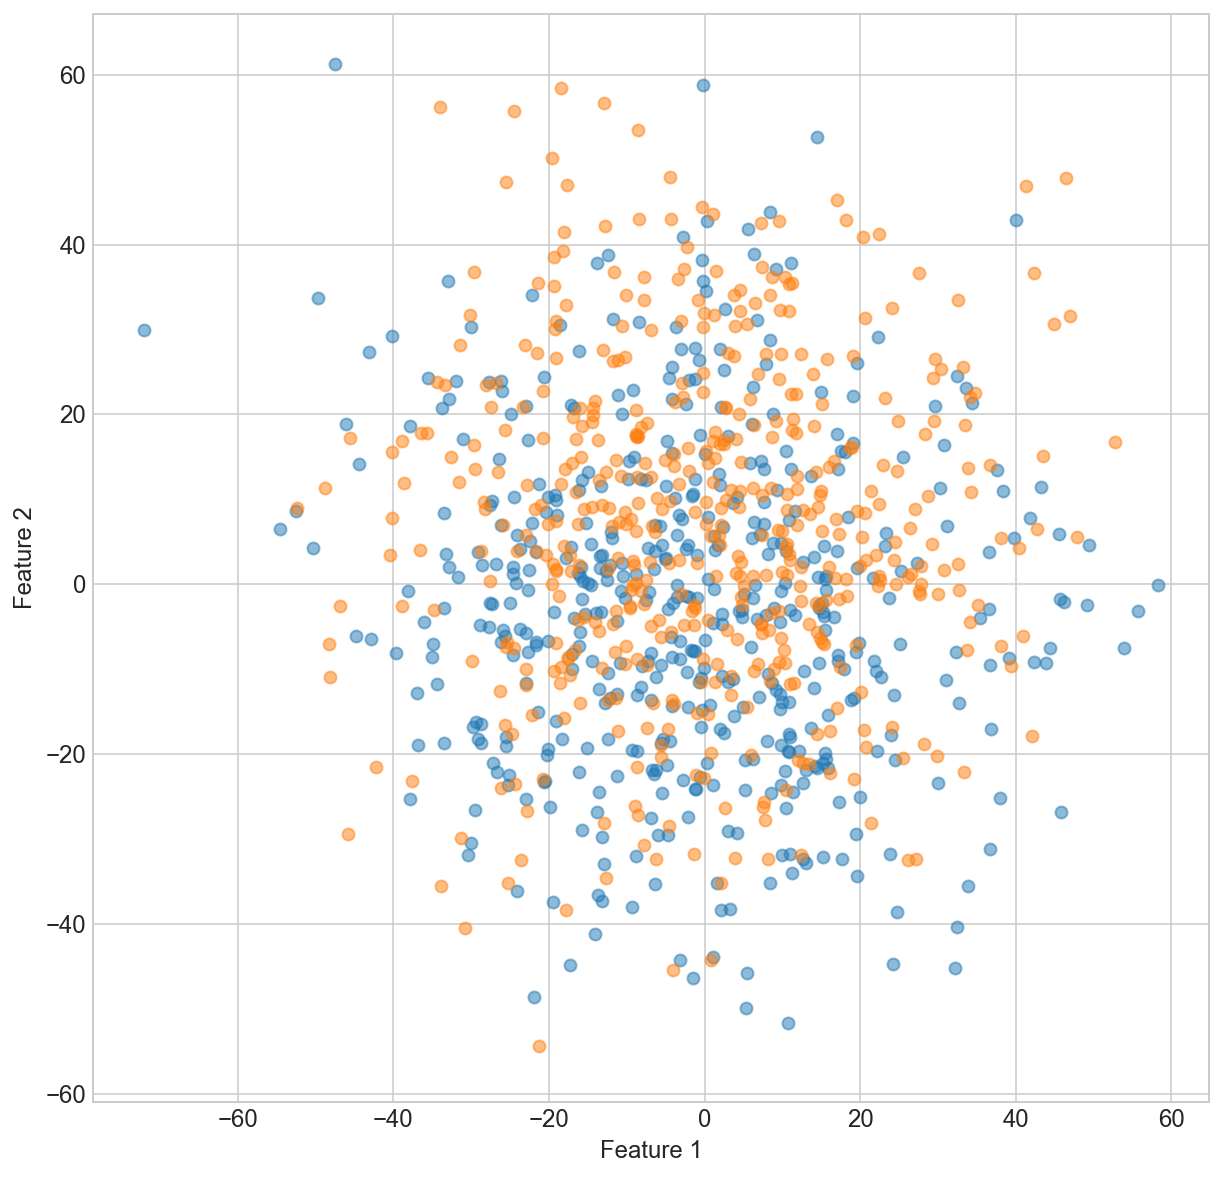

Chúng ta đã tạo ra
train X là một 2D array: (500, 20)
test X là một 2D array: (500, 20)
train y là một 1D array: (500,)
test y là một 1D array: (500,)
Cho một bài toán phân lớp 2 nhãn


In [15]:
train_X, train_Y, test_X, test_Y = create_dataset(labels = 2)

## Tạo hàm tính F1 score như 1 metric cho keras: Cách 1 - Dùng keras backend

Ở trạng thái mặc định, keras chỉ cung cấp một vài tiêu chí, thí dụ Accuracy, nhưng chúng ta hoàn toàn có thể tùy chọn tiêu chí theo ý thích bằng nhiều cách khác nhau. Tuy nhiên để có thể sử dụng được các tiêu chí tùy chọn này cho việc theo dõi, cập nhật (checkpoint) và kết thúc sớm (early stopping) thì ta phải đi sâu backend của keras hoặc viết hàm trong tensorflow. 

Trong thí dụ này, ta viết 1 hàm tính F1 score trong keras backend:

In [11]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Bước tiếp theo, ta phải tạo và đóng gói mô hình với tiêu chí mà ta đã chọn, thay vì dùng binary_accuracy như thường lệ. 

## Dựng mô hình sử dụng F1 score làm tiêu chí kiểm định

In [12]:
# Hàm dựng mô hình sử dụng F1 score

def create_model_F1(input_train = train_X,
                   output_train = train_Y,
                   drop = 0.5):

    # Cấu trúc mô hình

    model =Sequential()
    model.add(Dense(units = 128, input_dim = input_train.shape[1], activation='relu'))
    model.add(Dropout(drop))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(drop))
    model.add(Dense(1, activation='sigmoid'))
    
    # Đóng gói với F1 score

    model.compile(loss='binary_crossentropy', 
                  optimizer='adam',
                  metrics=[f1])

    print(model.summary())
    
    return model

model = create_model_F1()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               2688      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 11,009
Trainable params: 11,009
Non-trainable params: 0
_________________________________________________________________
None


## Thiết lập chế độ theo dõi, cập nhật và kết thúc sớm quy trình huấn luyện dựa vào tiêu chí F1 score

Như ta đã biết, mô hình Deep learning được huấn luyện qua nhiều lượt (epoch), sau mỗi lượt các giá trị weights trong mạng neurone sẽ được cập nhật và quy trình sẽ xuất ra kết quả kiểm định, quy trình này thông thường sẽ lặp lại cho đến hết số lượt định trước, và ta có mô hình sau cùng.

Tuy nhiên, ta có thể huấn luyện theo cách linh hoạt và hiệu quả hơn, thông qua 2 tính năng: Theo dõi/cập nhật (Checkpoint) và Kết thúc sớm (Early stopping). Với tính năng cập nhật, ta sẽ sao lưu theo chu kì (thí dụ vài epoches) các phiên bản mô hình khác nhau, tương ứng với các trạng thái khác nhau của quá trình huấn luyện,việc sao lưu chỉ được kích hoạt khi phẩm chất mô hình được nâng cao hơn phiên bản trước đó. Tính năng kết thúc sớm sẽ ngừng quy trình huấn luyện sau một số lượt nhất định mà mô hình không có sự cải thiện rõ. Cả 2 tính năng này đều cần tiêu chí để đánh giá hiệu năng cho mô hình. Thông thường ta hay chọn tiêu chí là hàm loss hay accuracy, nhưng ta cũng có thể dùng bất cứ tiêu chí nào mình thích, thí dụ F1, Kappa, AUC, ...

In [13]:
checkpoint = [ModelCheckpoint(filepath='temp/best_model.{epoch:03d}-{val_f1:.3f}.h5',
                             save_best_only=True, 
                             monitor='val_f1', 
                             mode='max', 
                             period=1, 
                             verbose=1),
             
             EarlyStopping(monitor='val_f1',
                      patience= 20, 
                      verbose=1)]

## Huấn luyện mô hình

In [16]:
hist = model.fit(train_X, train_Y, 
          epochs = 100,
          validation_data=[test_X, test_Y],
          batch_size = 8,
          callbacks = checkpoint)

Instructions for updating:
Use tf.cast instead.
Train on 500 samples, validate on 500 samples
Epoch 1/100
500/500 [==============================] - 3s 7ms/step - loss: 4.0919 - f1: 0.5124 - val_loss: 0.9583 - val_f1: 0.6835

Epoch 00001: val_f1 improved from -inf to 0.68352, saving model to temp/best_model.001-0.684.h5
Epoch 2/100
500/500 [==============================] - 0s 580us/step - loss: 2.4343 - f1: 0.6396 - val_loss: 0.6497 - val_f1: 0.8074

Epoch 00002: val_f1 improved from 0.68352 to 0.80735, saving model to temp/best_model.002-0.807.h5
Epoch 3/100
500/500 [==============================] - 0s 620us/step - loss: 1.4959 - f1: 0.7451 - val_loss: 0.6032 - val_f1: 0.8225

Epoch 00003: val_f1 improved from 0.80735 to 0.82252, saving model to temp/best_model.003-0.823.h5
Epoch 4/100
500/500 [==============================] - 0s 560us/step - loss: 1.1082 - f1: 0.7817 - val_loss: 0.6150 - val_f1: 0.8032

Epoch 00004: val_f1 did not improve from 0.82252
Epoch 5/100
500/500 [========

In [17]:
def F1_plot(history = None):
    plt.figure(figsize=(10,5))
    plt.plot(hist.history['f1'],'b-',label='Huấn luyện')
    plt.plot(hist.history['val_f1'],'r--', label='Kiểm định')
    plt.title('Giá trị F1 score')
    plt.ylabel('Giá trị F1 score')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10,5))
    plt.plot(hist.history['loss'],'b-', label='Huấn luyện')
    plt.plot(hist.history['val_loss'],'r--', label='Kiểm định')
    plt.title('Hàm Loss')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

Như ta thấy, lẽ ra ta việc huấn luyện được dự định làm trong 100 epoches, nhưng do ta đã kích hoạt Early stopping với thời gian chờ là 20 epoches, việc huấn luyện đã chấm dứt ở epoch 21. Ngoài ra, mỗi khi F1 score tăng cao hơn, phiên bản tại thời điểm đó được sao lưu vào đĩa. Ta có thể Load lại weights của phiên bản này bất cứ khi nào cần. Trong thí nghiệm này, ta dùng F1 score làm tiêu chí huấn luyện. Đây là 1 tiêu chí tốt cho bài toán nhị phân, nó cho phép cân bằng Recall và Precision theo cách tốt nhất.

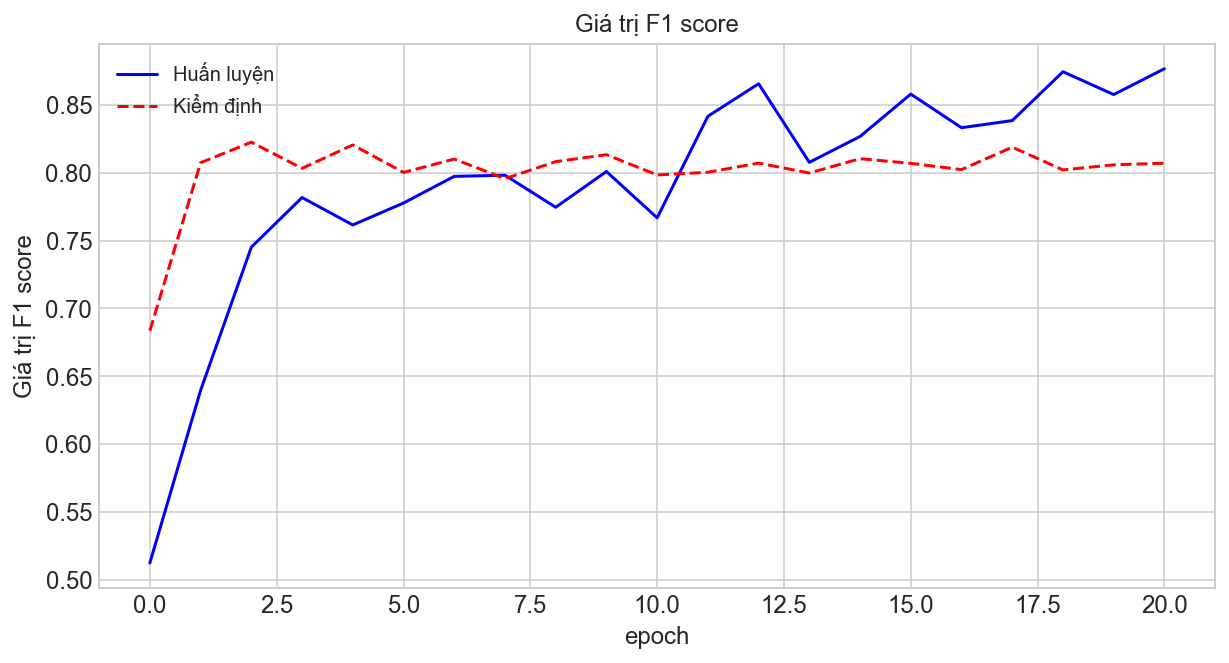

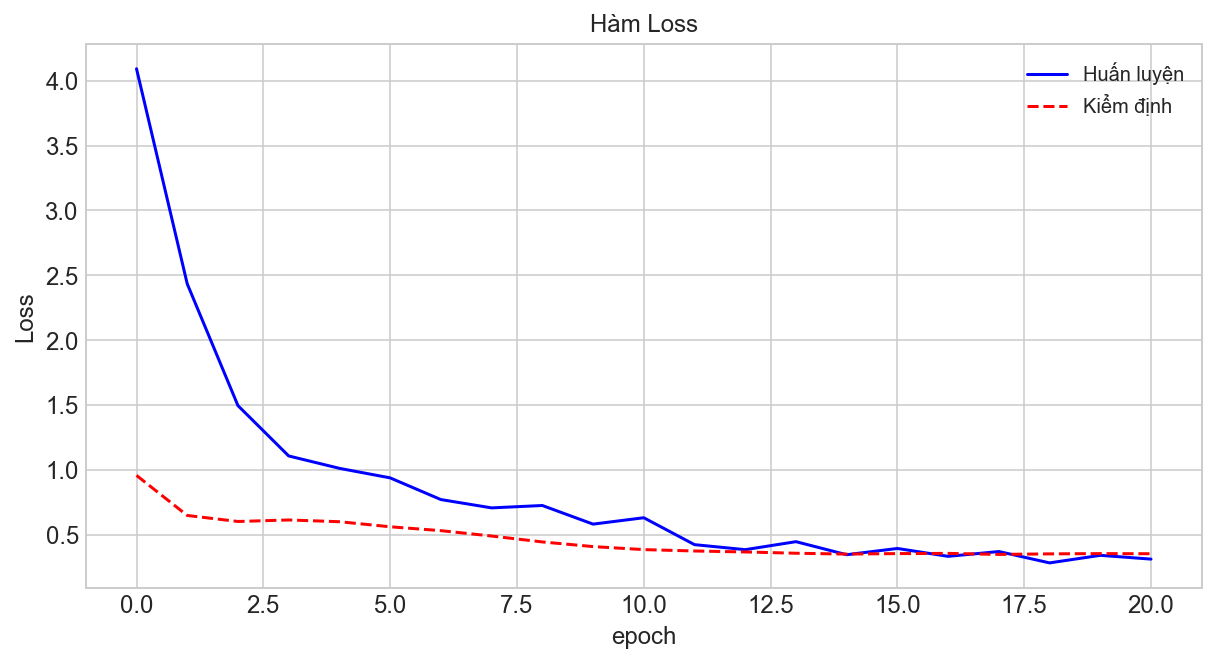

In [18]:
F1_plot(hist)

## Tạo hàm tính F1 score - Cách 2 - Dùng tensorflow contrib

Ở trên, ta tính F1 score thủ công bằng keras backend, tuy nhiên có cách làm khác đơn giản hơn nhiều, đó là sử dụng hàm f1_score trong tensorflow contrib module, như sau:

In [19]:
def F1(y_true, y_pred):
    return tf.contrib.metrics.f1_score(labels = y_true, 
                                       predictions = y_pred)[1]

Phần còn lại, ta làm tương tự như cách 1 :

In [20]:
def create_MLP_F1score(input_train = train_X,
                   output_train = train_Y,
                   drop = 0.5):

    model =Sequential()
    model.add(Dense(units = 128, input_dim = input_train.shape[1], activation='relu'))
    model.add(Dropout(drop))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(drop))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=[F1])
    
    print(model.summary())
    
    return model

model = create_MLP_F1score()

K.get_session().run(tf.local_variables_initializer())

C:\Users\bacsi\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               2688      
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
____________________________________________

In [22]:
# Tạo checkpoint mới dùng tiêu chí F1

checkpoint = [ModelCheckpoint(filepath='temp/best_model.{epoch:03d}-{val_F1:.3f}.h5',
                             save_best_only=True, 
                             monitor='val_F1', 
                             mode='max', 
                             period=1, 
                             verbose=1),
              
             EarlyStopping(monitor='val_F1',
                      patience= 20, 
                      verbose=1)]

# Huấn luyện

hist = model.fit(train_X, train_Y, 
          epochs = 100,
          validation_data=[test_X, test_Y],
          batch_size = 8,
          callbacks = checkpoint)

Train on 500 samples, validate on 500 samples
Epoch 1/100
500/500 [==============================] - 1s 2ms/step - loss: 4.7678 - F1: 0.6949 - val_loss: 1.5895 - val_F1: 0.6984

Epoch 00001: val_F1 improved from -inf to 0.69844, saving model to /tmp/model.h5
Epoch 2/100
500/500 [==============================] - 0s 639us/step - loss: 2.4389 - F1: 0.7196 - val_loss: 1.1463 - val_F1: 0.7423

Epoch 00002: val_F1 improved from 0.69844 to 0.74233, saving model to /tmp/model.h5
Epoch 3/100
500/500 [==============================] - 0s 580us/step - loss: 2.1711 - F1: 0.7549 - val_loss: 1.1875 - val_F1: 0.7636

Epoch 00003: val_F1 improved from 0.74233 to 0.76358, saving model to /tmp/model.h5
Epoch 4/100
500/500 [==============================] - 0s 620us/step - loss: 1.9474 - F1: 0.7678 - val_loss: 1.1178 - val_F1: 0.7751

Epoch 00004: val_F1 improved from 0.76358 to 0.77510, saving model to /tmp/model.h5
Epoch 5/100
500/500 [==============================] - 0s 580us/step - loss: 1.6228 - F

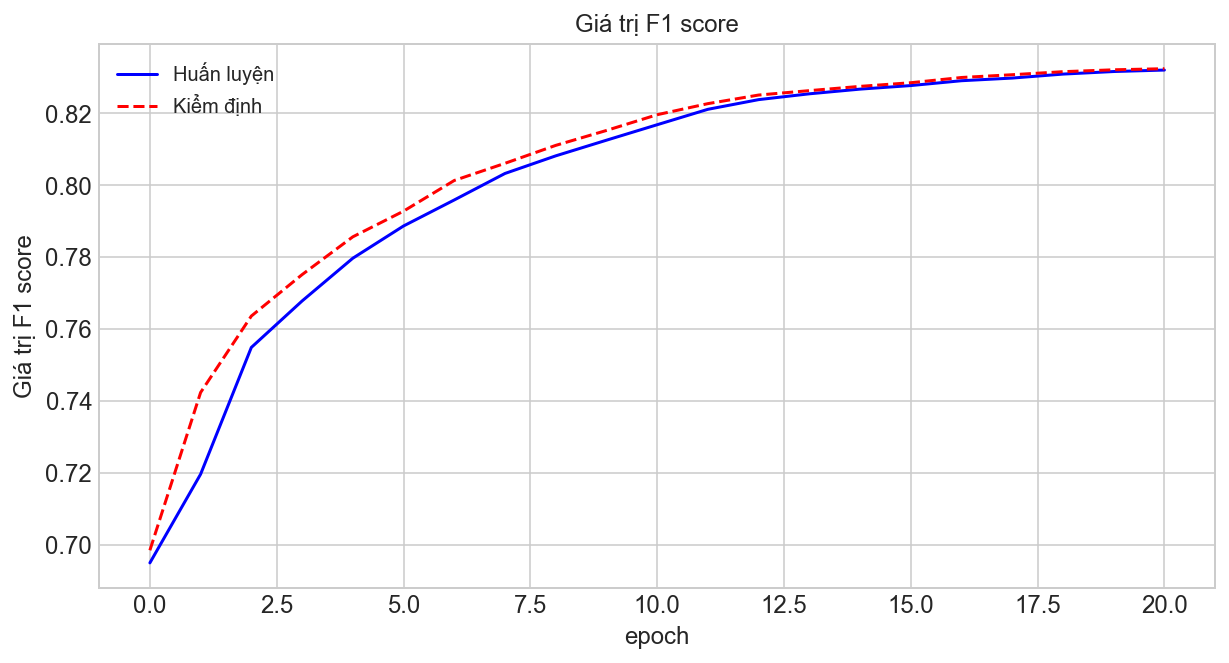

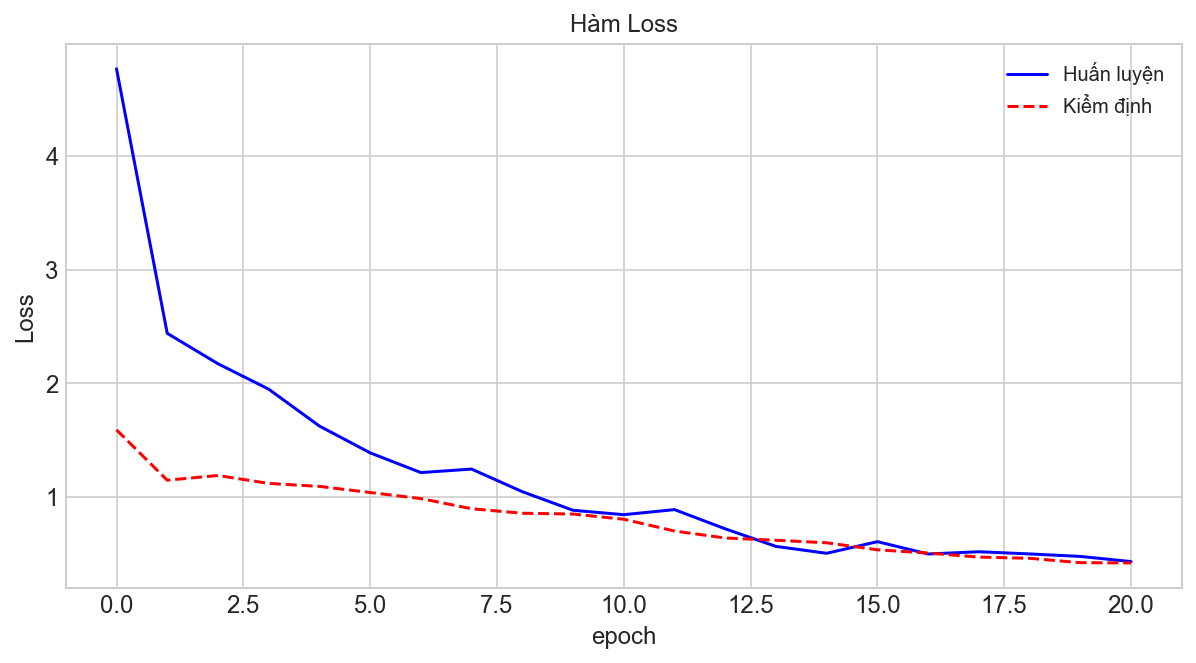

In [23]:
def F1_plot(history = None):
    plt.figure(figsize=(10,5))
    plt.plot(hist.history['F1'],'b-',label='Huấn luyện')
    plt.plot(hist.history['val_F1'],'r--', label='Kiểm định')
    plt.title('Giá trị F1 score')
    plt.ylabel('Giá trị F1 score')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10,5))
    plt.plot(hist.history['loss'],'b-', label='Huấn luyện')
    plt.plot(hist.history['val_loss'],'r--', label='Kiểm định')
    plt.title('Hàm Loss')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

F1_plot(hist)

# Bài toán phân lớp nhiều nhãn dùng Kappa làm tiêu chí theo dõi

## Tạo dữ liệu mô phỏng

Trong thử nghiệm thứ 2, Nhi sẽ áp dụng những tính năng trên cho 1 bài toán nhiều nhãn. Tiêu chí tùy chọn sẽ là Cohen's Kappa. Đây là metric rất tốt để tối ưu hóa hiệu năng mô hình phân loại khi có từ 3 nhãn trở lên. 

Ta cũng dùng hàm mô phỏnbg dữ liệu:

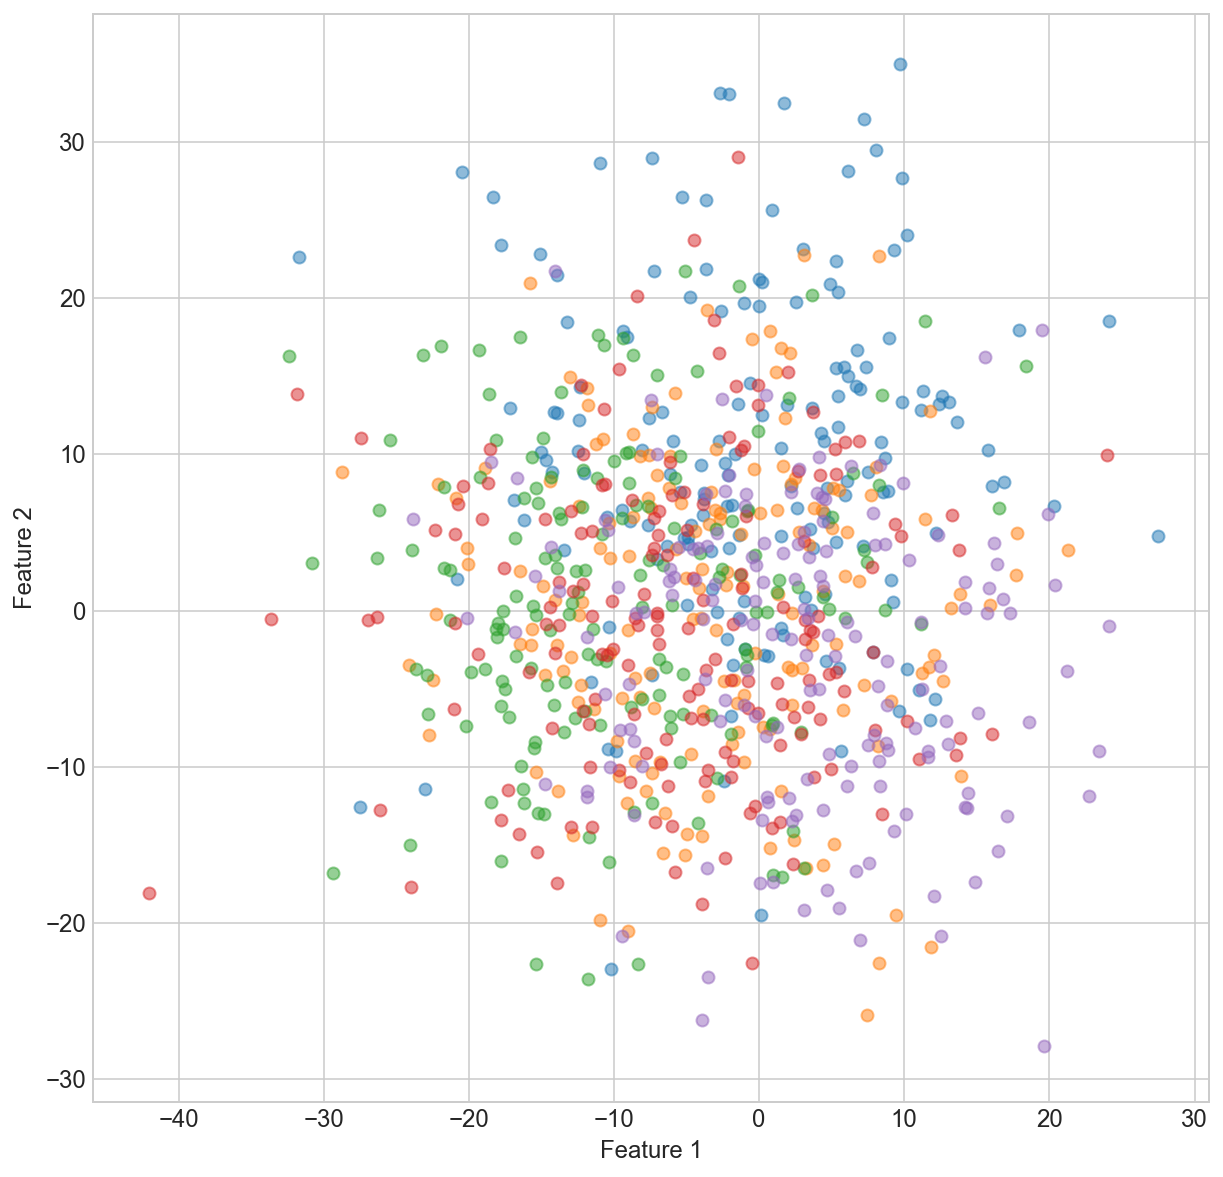

Chúng ta đã tạo ra
train X là một 2D array: (500, 20)
test X là một 2D array: (500, 20)
train y là một 1D array: (500,)
test y là một 1D array: (500,)
Cho một bài toán phân lớp 6 nhãn


In [41]:
train_X, train_Y, test_X, test_Y = create_dataset(labels = 6, noise_std = 10)

Cho mô hình Deep learning, vector kết quả Y được chuyển dạng thành một 2D array (One-hot encoding):

In [42]:
n_features = train_X.shape[1]

y_train = tf.keras.utils.to_categorical(train_Y)
y_test = tf.keras.utils.to_categorical(test_Y)

y_train

array([[0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)

Ta sử dụng thêm class_weights (sẽ có ích khi có hiện tượng mất cân bằng giữa các nhãn).

In [43]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(train_Y),train_Y)
class_weights

array([1.08225108, 0.95785441, 0.98039216, 0.98039216, 0.99206349,
       1.01626016])

## Tạo hàm tính Cohen's kappa sử dụng tensorflow contrib

Tương tự như trên, ta viết 1 hàm tính Cohen's kappa trong tensorflow, sau đó đưa hàm này như metric vào mô hình và chế độ huấn luyện. 

In [44]:
def cohens_kappa(y_true, y_pred, n_class = y_train.shape[1]):
    y_true_classes = tf.argmax(y_true, 1)
    y_pred_classes = tf.argmax(y_pred, 1)
    return tf.contrib.metrics.cohen_kappa(y_true_classes, 
                                          y_pred_classes, 
                                          num_classes = n_class)[1]

## Dựng và đóng gói mô hình phân lớp nhiều nhãn dùng Kappa như tiêu chí huấn luyện

In [56]:
def create_model_Kappa(input_train = train_X,
                   output_train = y_train,
                   drop = 0.5):

    model =Sequential()
    model.add(Dense(units = 128, input_dim = input_train.shape[1], activation='relu'))
    model.add(Dropout(drop))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(drop))
    model.add(Dense(output_train.shape[1], activation='softmax'))
    
    # Đóng gói với kappa metric
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=[cohens_kappa])
    
    print(model.summary())
    
    return model

model = create_model_Kappa()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 128)               2688      
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_20 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 6)                 390       
Total params: 11,334
Trainable params: 11,334
Non-trainable params: 0
_________________________________________________________________
None


## Chế độ theo dõi và sao lưu dựa vào kappa

In [57]:
K.get_session().run(tf.local_variables_initializer())

checkpoint = [ModelCheckpoint(filepath='temp/best_model.{epoch:03d}-{val_cohens_kappa:.3f}.h5',
                             save_best_only=True, 
                             monitor='val_cohens_kappa', 
                             mode='max', 
                             period=1, 
                             verbose=1),
              
             EarlyStopping(monitor='val_cohens_kappa',
                      patience= 200, 
                      verbose=1)]

## Huấn luyện mô hình 

In [58]:
hist = model.fit(train_X, y_train, 
          epochs = 300,
          validation_data=[test_X, y_test],
          batch_size = 128,
          class_weight = class_weights,
          callbacks = checkpoint)

Train on 500 samples, validate on 500 samples
Epoch 1/300
500/500 [==============================] - 1s 2ms/step - loss: 7.4408 - cohens_kappa: -0.0193 - val_loss: 3.0512 - val_cohens_kappa: 0.0316

Epoch 00001: val_cohens_kappa improved from -inf to 0.03162, saving model to temp/best_model.001-0.032.h5
Epoch 2/300
500/500 [==============================] - 0s 72us/step - loss: 6.3979 - cohens_kappa: 0.0484 - val_loss: 2.2245 - val_cohens_kappa: 0.0929

Epoch 00002: val_cohens_kappa improved from 0.03162 to 0.09285, saving model to temp/best_model.002-0.093.h5
Epoch 3/300
500/500 [==============================] - 0s 59us/step - loss: 6.5042 - cohens_kappa: 0.1094 - val_loss: 1.7134 - val_cohens_kappa: 0.1391

Epoch 00003: val_cohens_kappa improved from 0.09285 to 0.13914, saving model to temp/best_model.003-0.139.h5
Epoch 4/300
500/500 [==============================] - 0s 60us/step - loss: 5.4155 - cohens_kappa: 0.1523 - val_loss: 1.3894 - val_cohens_kappa: 0.1786

Epoch 00004: val_c

500/500 [==============================] - 0s 55us/step - loss: 1.2834 - cohens_kappa: 0.5128 - val_loss: 0.6008 - val_cohens_kappa: 0.5155

Epoch 00032: val_cohens_kappa improved from 0.51134 to 0.51547, saving model to temp/best_model.032-0.515.h5
Epoch 33/300
500/500 [==============================] - 0s 60us/step - loss: 1.1624 - cohens_kappa: 0.5174 - val_loss: 0.6002 - val_cohens_kappa: 0.5204

Epoch 00033: val_cohens_kappa improved from 0.51547 to 0.52040, saving model to temp/best_model.033-0.520.h5
Epoch 34/300
500/500 [==============================] - 0s 61us/step - loss: 1.1876 - cohens_kappa: 0.5218 - val_loss: 0.6005 - val_cohens_kappa: 0.5245

Epoch 00034: val_cohens_kappa improved from 0.52040 to 0.52451, saving model to temp/best_model.034-0.525.h5
Epoch 35/300
500/500 [==============================] - 0s 60us/step - loss: 1.0809 - cohens_kappa: 0.5260 - val_loss: 0.6019 - val_cohens_kappa: 0.5284

Epoch 00035: val_cohens_kappa improved from 0.52451 to 0.52837, saving

500/500 [==============================] - 0s 53us/step - loss: 0.8470 - cohens_kappa: 0.6004 - val_loss: 0.5632 - val_cohens_kappa: 0.6015

Epoch 00063: val_cohens_kappa improved from 0.59970 to 0.60149, saving model to temp/best_model.063-0.601.h5
Epoch 64/300
500/500 [==============================] - 0s 60us/step - loss: 0.8621 - cohens_kappa: 0.6022 - val_loss: 0.5638 - val_cohens_kappa: 0.6031

Epoch 00064: val_cohens_kappa improved from 0.60149 to 0.60308, saving model to temp/best_model.064-0.603.h5
Epoch 65/300
500/500 [==============================] - 0s 58us/step - loss: 0.8732 - cohens_kappa: 0.6038 - val_loss: 0.5629 - val_cohens_kappa: 0.6049

Epoch 00065: val_cohens_kappa improved from 0.60308 to 0.60490, saving model to temp/best_model.065-0.605.h5
Epoch 66/300
500/500 [==============================] - 0s 80us/step - loss: 0.7925 - cohens_kappa: 0.6056 - val_loss: 0.5609 - val_cohens_kappa: 0.6066

Epoch 00066: val_cohens_kappa improved from 0.60490 to 0.60664, saving

500/500 [==============================] - 0s 60us/step - loss: 0.6173 - cohens_kappa: 0.6467 - val_loss: 0.5076 - val_cohens_kappa: 0.6474

Epoch 00094: val_cohens_kappa improved from 0.64630 to 0.64741, saving model to temp/best_model.094-0.647.h5
Epoch 95/300
500/500 [==============================] - 0s 40us/step - loss: 0.6868 - cohens_kappa: 0.6477 - val_loss: 0.5091 - val_cohens_kappa: 0.6484

Epoch 00095: val_cohens_kappa improved from 0.64741 to 0.64836, saving model to temp/best_model.095-0.648.h5
Epoch 96/300
500/500 [==============================] - 0s 64us/step - loss: 0.7044 - cohens_kappa: 0.6488 - val_loss: 0.5109 - val_cohens_kappa: 0.6493

Epoch 00096: val_cohens_kappa improved from 0.64836 to 0.64930, saving model to temp/best_model.096-0.649.h5
Epoch 97/300
500/500 [==============================] - 0s 60us/step - loss: 0.7094 - cohens_kappa: 0.6498 - val_loss: 0.5125 - val_cohens_kappa: 0.6503

Epoch 00097: val_cohens_kappa improved from 0.64930 to 0.65035, saving

500/500 [==============================] - 0s 40us/step - loss: 0.5157 - cohens_kappa: 0.6760 - val_loss: 0.4980 - val_cohens_kappa: 0.6764

Epoch 00125: val_cohens_kappa improved from 0.67552 to 0.67639, saving model to temp/best_model.125-0.676.h5
Epoch 126/300
500/500 [==============================] - 0s 63us/step - loss: 0.5658 - cohens_kappa: 0.6767 - val_loss: 0.4975 - val_cohens_kappa: 0.6772

Epoch 00126: val_cohens_kappa improved from 0.67639 to 0.67723, saving model to temp/best_model.126-0.677.h5
Epoch 127/300
500/500 [==============================] - 0s 60us/step - loss: 0.5086 - cohens_kappa: 0.6777 - val_loss: 0.4971 - val_cohens_kappa: 0.6781

Epoch 00127: val_cohens_kappa improved from 0.67723 to 0.67810, saving model to temp/best_model.127-0.678.h5
Epoch 128/300
500/500 [==============================] - 0s 63us/step - loss: 0.5248 - cohens_kappa: 0.6784 - val_loss: 0.4945 - val_cohens_kappa: 0.6789

Epoch 00128: val_cohens_kappa improved from 0.67810 to 0.67889, sav

500/500 [==============================] - 0s 65us/step - loss: 0.5083 - cohens_kappa: 0.6975 - val_loss: 0.4949 - val_cohens_kappa: 0.6978

Epoch 00156: val_cohens_kappa improved from 0.69726 to 0.69785, saving model to temp/best_model.156-0.698.h5
Epoch 157/300
500/500 [==============================] - 0s 60us/step - loss: 0.4778 - cohens_kappa: 0.6981 - val_loss: 0.4942 - val_cohens_kappa: 0.6984

Epoch 00157: val_cohens_kappa improved from 0.69785 to 0.69841, saving model to temp/best_model.157-0.698.h5
Epoch 158/300
500/500 [==============================] - 0s 40us/step - loss: 0.4665 - cohens_kappa: 0.6987 - val_loss: 0.4932 - val_cohens_kappa: 0.6990

Epoch 00158: val_cohens_kappa improved from 0.69841 to 0.69901, saving model to temp/best_model.158-0.699.h5
Epoch 159/300
500/500 [==============================] - 0s 63us/step - loss: 0.5054 - cohens_kappa: 0.6993 - val_loss: 0.4922 - val_cohens_kappa: 0.6996

Epoch 00159: val_cohens_kappa improved from 0.69901 to 0.69958, sav

500/500 [==============================] - 0s 43us/step - loss: 0.4334 - cohens_kappa: 0.7144 - val_loss: 0.4892 - val_cohens_kappa: 0.7147

Epoch 00187: val_cohens_kappa improved from 0.71414 to 0.71467, saving model to temp/best_model.187-0.715.h5
Epoch 188/300
500/500 [==============================] - 0s 41us/step - loss: 0.4261 - cohens_kappa: 0.7148 - val_loss: 0.4904 - val_cohens_kappa: 0.7151

Epoch 00188: val_cohens_kappa improved from 0.71467 to 0.71510, saving model to temp/best_model.188-0.715.h5
Epoch 189/300
500/500 [==============================] - 0s 43us/step - loss: 0.4281 - cohens_kappa: 0.7153 - val_loss: 0.4937 - val_cohens_kappa: 0.7155

Epoch 00189: val_cohens_kappa improved from 0.71510 to 0.71553, saving model to temp/best_model.189-0.716.h5
Epoch 190/300
500/500 [==============================] - 0s 60us/step - loss: 0.3864 - cohens_kappa: 0.7158 - val_loss: 0.4974 - val_cohens_kappa: 0.7160

Epoch 00190: val_cohens_kappa improved from 0.71553 to 0.71604, sav

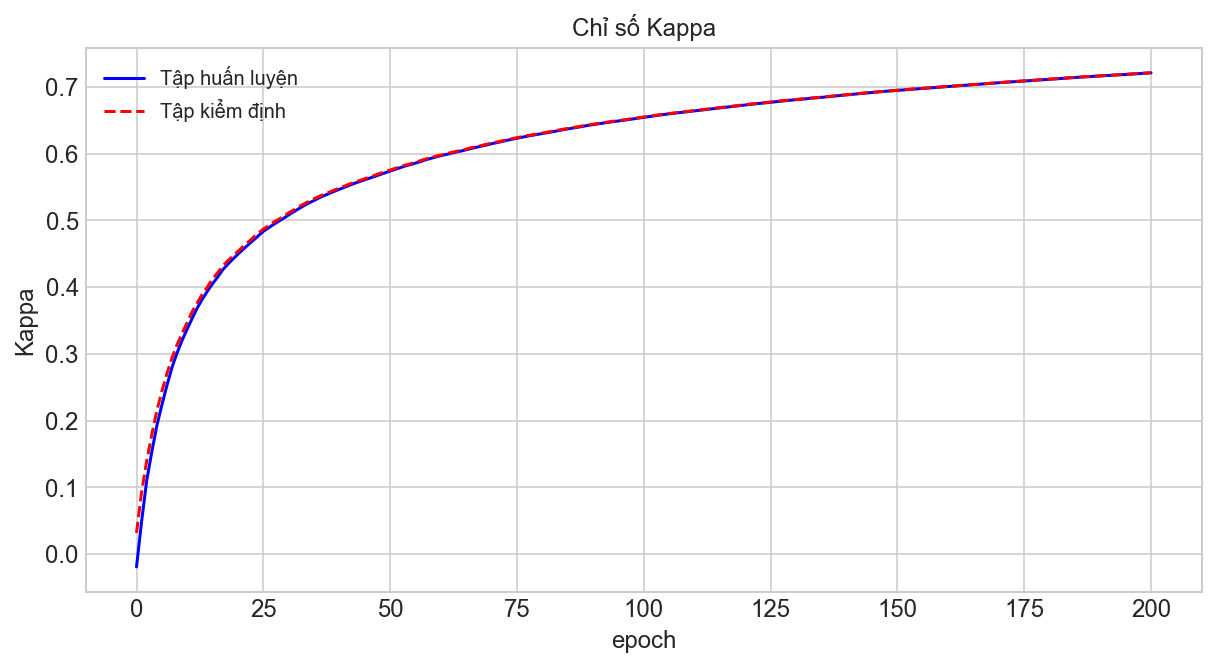

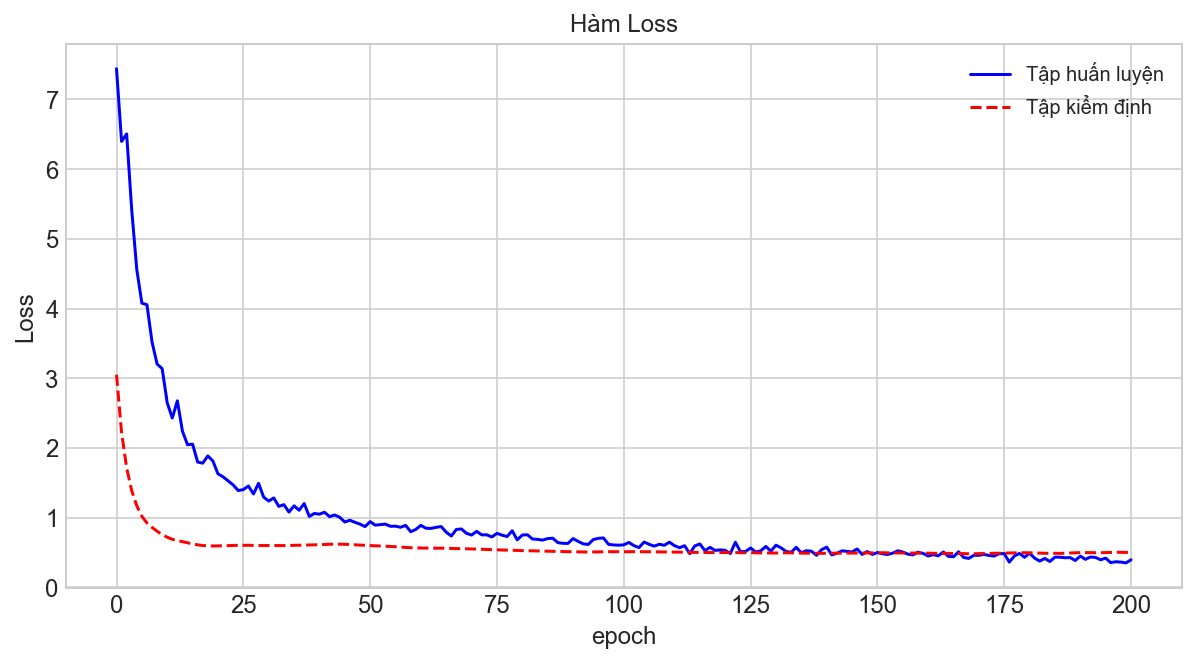

In [60]:
def kappa_plot(history = None):
    plt.figure(figsize=(10,5))
    plt.plot(hist.history['cohens_kappa'],'b-',label='Tập huấn luyện')
    plt.plot(hist.history['val_cohens_kappa'],'r--', label='Tập kiểm định')
    plt.title('Chỉ số Kappa')
    plt.ylabel('Kappa')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10,5))
    plt.plot(hist.history['loss'],'b-', label='Tập huấn luyện')
    plt.plot(hist.history['val_loss'],'r--', label='Tập kiểm định')
    plt.title('Hàm Loss')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

kappa_plot(hist)

Như vậy các bạn đã quen với việc sử dụng tính năng theo dõi và cập nhật quy trình huấn luyện mô hình trong keras, hơn nữa bạn có thể dùng tiêu chí tùy chọn cho quy trình này.

Ngoài tính linh hoạt trong cấu trúc mạng neurone cho phép nó thích ứng với nhiều dạng dữ liệu thì khả năng cập nhật mô hình trên dữ liệu mới hay dòng dữ liệu liên tục, cũng như khả năng theo dõi và kiểm soát quy trình huấn luyện là những ưu thế nổi bật của Deep learning so với những loại algorithm machine learning khác.

Hẹn gặp lại các bạn trong thí nghiệm khác.